In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("../data/archive.hdf5", 'r')

In [3]:
class Spectrum(object): 
    def __init__(self, wl, fl): 
#         wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl#[wl_range]
        self.flux = fl#[wl_range]

In [4]:
# spectra = []
# keys = list(archive)
# for isot in keys: 
#     sp = Spectrum(*archive[isot][:])
#     spectra.append(sp)

In [5]:
keys = list(archive)

In [5]:
dx = np.load('cnn/dx.npy')

In [6]:
wl, f = archive[keys[0]][:]

# coadded = f

# delta_wavelength = np.median(np.diff(w))
    
# for i in range(0, len(keys)): 
#     # Quality filter
#     w, f = archive[keys[i]][:]
#     if f.max() < 2:
#         wavelength_shift = dx[i] * delta_wavelength
#         rolled_spectrum = np.interp(wl, w - wavelength_shift, f, left=1, right=1)
        
#         coadded += rolled_spectrum

In [7]:
# np.save('data/sun_coadded.npy', coadded)

coadded = np.load('data/sun_coadded.npy')

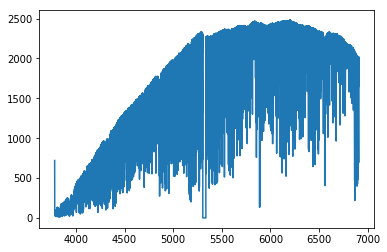

In [8]:
plt.plot(wl, coadded)
# plt.xlim([5880, 5900])

In [9]:
with open('data/48Ti-16O__Plez2012-norlander_e2/Out_00000_33000_02900_n800.bin') as f: 
    array = np.fromfile(f, dtype=np.int32)

In [10]:
import astropy.units as u

wavelengths = (np.arange(0, 33000, 1e-2)*u.k).to(u.Angstrom, u.spectral()).value
cross_section = array

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy/units/equivalencies.py:93: RuntimeWarning: divide by zero encountered in true_divide
  (si.m, inv_m_spec, lambda x: 1.0 / x),


In [11]:
np.save('data/tio.npy', np.vstack([wavelengths, cross_section]))

(1000000000.0, 1300000000.0)

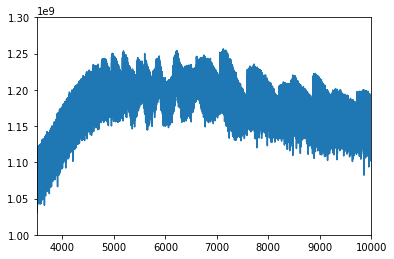

In [12]:
plt.plot(wavelengths, cross_section)
plt.xlim([3500, 10000])
plt.ylim([1e9, 1.3e9])

In [13]:
inrange = (wavelengths < 7000) & (wavelengths > 4000)
tio_wl = wavelengths[inrange]
tio_cross = cross_section[inrange] - np.median(cross_section[inrange])
tio_cross /= np.std(tio_cross)

In [14]:
tio_wl[1] - tio_wl[2]

0.004899985789961647

In [15]:
binsize = wl[1] - wl[0]
binedges = np.linspace(wl.min() - binsize/2, wl.max() + binsize/2, len(wl) + 1)

from scipy.stats import binned_statistic

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.


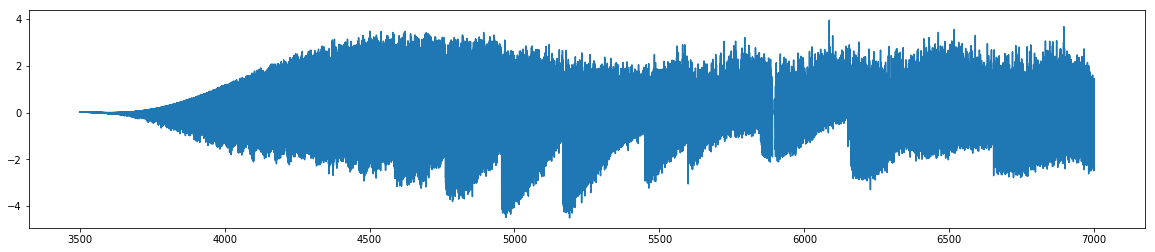

In [43]:
from astropy.io import fits

f = fits.getdata('data/WASP-121b_no_VO_occultation.fits')

tio_wl = f[0, :] * 10
tio_trans = f[1, :]

sodium_doublet = (tio_wl < 5900) & (tio_wl > 5890)

tio_trans -= np.polyval(np.polyfit(tio_wl, tio_trans, 10), tio_wl)

tio_trans /= np.std(tio_trans)

tio_trans[sodium_doublet] = 0
plt.figure(figsize=(20, 4))
plt.plot(tio_wl, tio_trans)
# plt.xlim(589, 590)
# plt.ylim([])

In [38]:
from scipy.ndimage import gaussian_filter1d

(-2, 2)

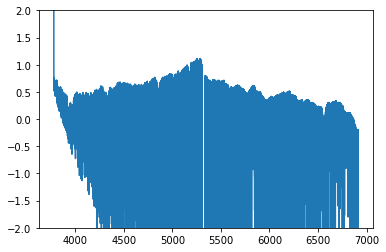

In [53]:
detrend_coadded = coadded - np.polyval(np.polyfit(wl, coadded, 2), wl)

detrend_coadded /= detrend_coadded.std()

plt.plot(wl, detrend_coadded)
plt.ylim([-2, 2])

In [57]:
tio_smoothed = gaussian_filter1d(tio_trans, (wl[1]-wl[0]) / (tio_wl[1] - tio_wl[0]))

tio_interp = np.interp(wl, tio_wl, tio_smoothed)

In [71]:
from scipy.signal import fftconvolve

convolution = fftconvolve(detrend_coadded, tio_interp, mode='full')

-85939


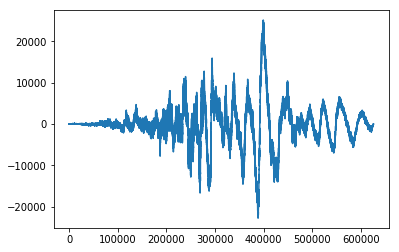

In [75]:
plt.plot(convolution)

dx = convolution.shape[0]//2 - np.argmax(convolution)
print(dx)

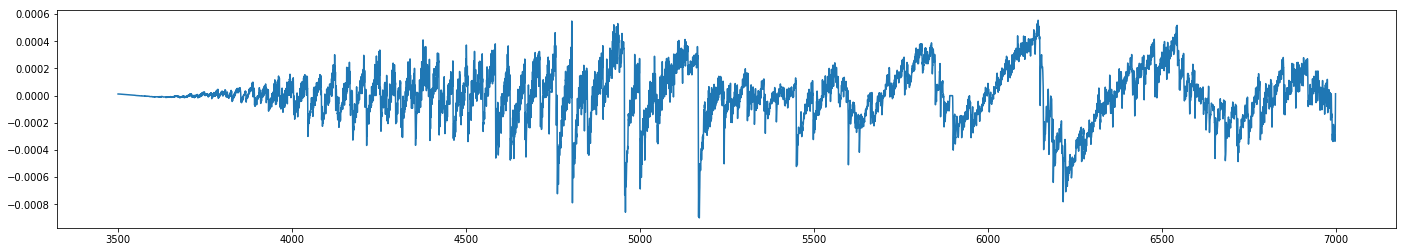

In [39]:
plt.figure(figsize=(24, 4))
plt.plot(tio_wl, gaussian_filter1d(tio_trans, 100))